In [1]:
import pandas as pd
import altair as alt
from pandas_profiling import ProfileReport

In [2]:
# Handle large data sets by not embedding them in the notebook
alt.data_transformers.enable('data_server')

# Save a PNG blob as a backup for when the Altair plots do not render
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

In [3]:
stock_price_trend_df = pd.read_csv('../data/prices_trends_merged_data.csv')

In [4]:
stock_price_trend_df

,week,weekly_interest,symbol,open,adj_close
0,2020-07-05,40,FOX,26.940001,24.860155
1,2020-07-12,44,FOX,25.379999,24.732868
2,2020-07-19,44,FOX,25.080000,25.937201
3,2020-07-26,46,FOX,26.379999,25.232225
4,2020-08-02,45,FOX,25.870001,24.370590
...,...,...,...,...,...
17467,2021-05-30,55,BLK,887.900024,878.887817
17468,2021-06-06,79,BLK,888.659973,876.834106
17469,2021-06-13,42,BLK,881.000000,837.127441
17470,2021-06-20,67,BLK,849.000000,870.232971


In [5]:
# Calculating the weekly price change as a percentage
stock_price_trend_df['price_change_pct'] = (stock_price_trend_df['adj_close'] - stock_price_trend_df['open']) / stock_price_trend_df['open']
stock_price_trend_df

,week,weekly_interest,symbol,open,adj_close,price_change_pct
0,2020-07-05,40,FOX,26.940001,24.860155,-0.077203
1,2020-07-12,44,FOX,25.379999,24.732868,-0.025498
2,2020-07-19,44,FOX,25.080000,25.937201,0.034179
3,2020-07-26,46,FOX,26.379999,25.232225,-0.043509
4,2020-08-02,45,FOX,25.870001,24.370590,-0.057959
...,...,...,...,...,...,...
17467,2021-05-30,55,BLK,887.900024,878.887817,-0.010150
17468,2021-06-06,79,BLK,888.659973,876.834106,-0.013308
17469,2021-06-13,42,BLK,881.000000,837.127441,-0.049799
17470,2021-06-20,67,BLK,849.000000,870.232971,0.025009


In [6]:
# Explore the dataset at a first glance by Pandas Profiling
profile = ProfileReport(stock_price_trend_df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
profile.to_file("stock-price-trend-eda_pandas-profiling-report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# Calculating the standard deviation of the price change percentage for each stock
stock_price_stds = stock_price_trend_df.groupby('symbol').agg({'price_change_pct': 'std'})
stock_price_stds

,price_change_pct
symbol,
AAL,0.062810
AAP,0.037851
AAPL,0.041034
ABBV,0.030771
ABC,0.035948
...,...
T,0.030373
TAP,0.042804
TECH,0.047673


In [9]:
# Plotting the standard deviations of the price change percentages for all stocks as a distribution
plt_price_stds = alt.Chart(stock_price_stds, title='Distribution of Price Change Volatility').mark_bar().encode(
    x=alt.X('price_change_pct', bin=alt.Bin(maxbins=100), title='Stock Price Weekly Percentage Change (StDev)'),
    y=alt.Y('count()',
            title='Count of Stocks'),
)


In [10]:
# Calculating the standard deviation of the weekly interest on google trends for each stock
stock_trends_stds = stock_price_trend_df.groupby('symbol').agg({'weekly_interest': 'std'})
stock_trends_stds

,weekly_interest
symbol,
AAL,17.817017
AAP,16.372318
AAPL,15.370438
ABBV,17.497716
ABC,8.776082
...,...
T,5.656454
TAP,12.784367
TECH,10.329781


In [11]:
# Plotting the standard deviations of the price change percentages for all stocks as a distribution
plt_trends_stds = alt.Chart(stock_trends_stds,
                            title='Distribution of Stock Interest Volatility').mark_bar().encode(
    x=alt.X('weekly_interest',
              bin=alt.Bin(maxbins=100),
              title='Weekly Google Search Trend (StDev)'),
    y=alt.Y('count()',
              title='Count of Stocks'))


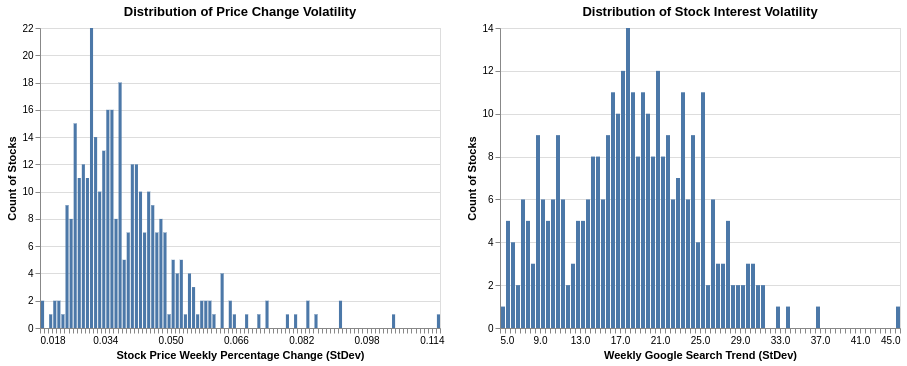

In [12]:
plt_price_stds | plt_trends_stds

### Discussion

Above we plot histograms of the standard deviations of returns and trends of around 330 stocks selected from the S&P500.

For the returns, we observe a right-skewed normal distribution. This means that while relatively normally distributed, there are more outliers on the right tail of the distribution than a pure normal distribution.

For the trends, we observe a more normal distribution than for the returns. There may be some evidence of bi-modality in these data, but it could simply be an artifact of the bin selection. If bi-modality exists, there seems to be a smaller cluster of stocks with low trend volatility and a larger cluster of stocks centred around medium trend volatility. 

The question for this basic analysis is if there is a mapping between the variability across these two histograms. Are stocks in the lower side of the return volatility also in the lower side of the trend volatility?

In [13]:
# Calculating the standard deviation of the weekly interest on google trends and price change percentage for each stock
stock_trends_prices_stds = stock_price_trend_df.groupby('symbol').agg({'weekly_interest': 'std', 'price_change_pct': 'std'})
stock_trends_prices_stds

,weekly_interest,price_change_pct
symbol,,
AAL,17.817017,0.062810
AAP,16.372318,0.037851
AAPL,15.370438,0.041034
ABBV,17.497716,0.030771
ABC,8.776082,0.035948
...,...,...
T,5.656454,0.030373
TAP,12.784367,0.042804
TECH,10.329781,0.047673


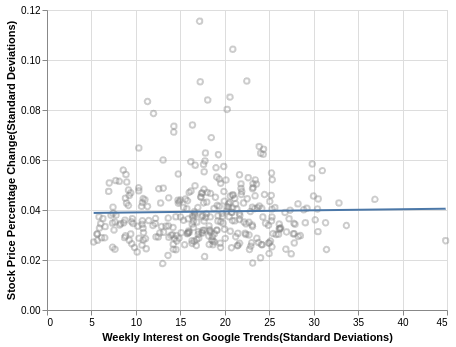

In [14]:
plt_trends_prices_stds = alt.Chart(stock_trends_prices_stds).mark_point(opacity=0.4, color='gray').encode(
    x=alt.X('weekly_interest', title='Weekly Interest on Google Trends(Standard Deviations)'),
    y=alt.Y('price_change_pct', title='Stock Price Percentage Change(Standard Deviations)')
)

# plt_trends_prices_stds + plt_trends_prices_stds.transform_loess('weekly_interest', 'price_change_pct', bandwidth=0.8).mark_line(size=3)
plt_trends_prices_stds + plt_trends_prices_stds.transform_regression('weekly_interest', 'price_change_pct').mark_line()

### Discussion

From the basic regression analysis, we do not observe an obvious trend in the data. It seems as if information on search trend volatility provides remarkably little information on the return volatility. 

While these results are not promising, as discussed in the project proposal, we can perhaps assess this relationship on particular clusters of stocks to see if a relationship exists for certain categories (i.e. tech stocks). 

We can also look to expand our features of search volatility. For example, while we use stock tickers for this EDA, we can perhaps use the company names or other adjacent searches in our volatility analysis. 